In [1]:
import pandas as pd
import numpy as np
from typing import Any, Tuple
import os, sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def nodes_for_workflow(workflow_id: Any, db: Any) -> pd.DataFrame:
    return pd.read_sql_query("""
        SELECT *
          FROM node
         WHERE run_id='%s';
        """ % (workflow_id), db)


def resources_for_workflow(workflow_id: Any, db: Any) -> pd.DataFrame:
    return pd.read_sql_query("""
        SELECT *
          FROM resource
         WHERE run_id='%s';
        """ % (workflow_id), db)


def tasks_for_workflow(workflow_id: Any, db: Any) -> pd.DataFrame:
    return pd.read_sql_query("""
                             SELECT *
                              FROM task
                             Where run_id='%s';
                             """ % (workflow_id), db)

def resource_efficiency(resource, node):
    try:
        label = "CPU"
        resource['epoch_time'] = (pd.to_datetime(
            resource['timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        node['epoch_time'] = (pd.to_datetime(
            node['timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        resource = resource.sort_values(by='epoch_time')
        start = min(resource['epoch_time'].min(), node['epoch_time'].min())
        end = resource['epoch_time'].max()
        resource['relative_time'] = resource['epoch_time'] - start
        node['relative_time'] = node['epoch_time'] - start
        resource['key'] = resource['task_id'].astype(str) + "-" + resource['try_id'].astype(str)

        task_plot = [0] * (end - start + 1)
        if label == 'CPU':
            total = node['cpu_count'].sum()
        elif label == 'mem':
            total = node['total_memory'].sum() / 1024 / 1024 / 1024

        resource['total_cpu_time'] = resource['psutil_process_time_user'] + resource['psutil_process_time_system']
        for key in resource['key'].unique():
            tmp = resource[resource['key'] == key]
            tmp['last_timestamp'] = tmp['relative_time'].shift(1)
            if label == 'CPU':
                tmp['last_cputime'] = tmp['total_cpu_time'].shift(1)
            for index, row in tmp.iterrows():
                if np.isnan(row['last_timestamp']):
                    continue
                for i in range(int(row['last_timestamp']), int(row['relative_time'])):
                    if label == 'CPU':
                        diff = (row['total_cpu_time'] - row['last_cputime']) / (row['relative_time'] - row['last_timestamp'])
                    elif label == 'mem':
                        diff = row['psutil_process_memory_resident'] / 1024 / 1024 / 1024
                    task_plot[i] += diff

        if label == 'CPU':
            name1 = 'Used CPU cores'
            name2 = 'Total CPU cores'
            yaxis = 'Number of CPU cores'
            title = 'CPU usage'
        elif label == 'mem':
            name1 = 'Used memory'
            name2 = 'Total memory'
            yaxis = 'Memory (GB)'
            title = 'Memory usage'


        return {"x": (end-start + 1), "y":task_plot}
    except Exception as e:
        print(e)
        return "The resource efficiency plot cannot be generated because of exception {}.".format(e)

In [3]:
def get_data(db_path, run_id):
    nodes = None
    resources = None
    monitoring_db_file = os.path.join(db_path, "monitoring.db")
    if os.path.exists(monitoring_db_file):
        with sqlite3.connect(monitoring_db_file) as connection:
            nodes = nodes_for_workflow(run_id, connection)
            resources = resources_for_workflow(run_id, connection)
    return resource_efficiency(resources, nodes)
def load_tasks(db_path, run_id):
    tasks = None
    monitoring_db_file = os.path.join(db_path, "monitoring.db")
    if os.path.exists(monitoring_db_file):
        with sqlite3.connect(monitoring_db_file) as connection:
            tasks = tasks_for_workflow(run_id, connection)
            tasks[tasks['task_time_returned'].notnull() & tasks['task_time_invoked'].notnull()] #select only the items with valid timestamps
            tasks['task_time_returned'] = pd.to_datetime(tasks['task_time_returned'], errors='coerce')
            tasks['task_time_invoked'] = pd.to_datetime(tasks['task_time_invoked'], errors='coerce')
            tasks = tasks[tasks['task_time_returned'].notna() & tasks['task_time_invoked'].notna()] #drop NaT items
            tasks.loc[:, 'runtime'] = tasks['task_time_returned'] - tasks['task_time_invoked']
            tasks.loc[:, 'runtime_seconds'] = tasks['runtime'].dt.total_seconds()
        return tasks

def task_runtime_per_gene(df):
    tasks_name = [[],[], [], [], [], [], [], [], []]
    tasks_time = [[],[], [], [], [], [], [], [], []]
    for i, r in df.iterrows():
        tasks_name[int(r["task_id"]) % 9].append(r["task_func_name"])
        tasks_time[int(r["task_id"]) % 9].append(float(r["runtime_seconds"]))
    #time per gene
    for t in tasks_name:
        print(t)
    time_per_gene = dict()
    for i in range(0, len(tasks_name[0])): #40 genes
        sum_ = 0
        for j in range(0, len(tasks_name)): #9 apps
            sum_+=tasks_time[j][i]
        time_per_gene[f"gene {i+1}"] = sum_
    return time_per_gene
def average_time_per_task(df):
    tasks_name = [[],[], [], [], [], [], [], [], []]
    tasks_time = [[],[], [], [], [], [], [], [], []]
    time_per_task = dict()
    for i, r in df.iterrows():
        tasks_name[int(r["task_id"]) % 9].append(r["task_func_name"])
        tasks_time[int(r["task_id"]) % 9].append(float(r["runtime_seconds"]))
    for i in range(0, len(tasks_name)):
        time_per_task[tasks_name[i][0]] = (sum(tasks_time[i])/len(tasks_time[i]))/60
    return time_per_task
            


# Calculating the CPU usage by time for each execution

## HyPhy

In [ ]:
hyphy_1_node = get_data("./hyphy/runinfo", "dff22135-256c-4f04-904e-d8b5aad762fa")
hyphy_2_nodes = get_data("./hyphy/runinfo_multiple_nodes", "0d081c02-5ace-44de-b22a-1b0d2123843f")
hyphy_3_nodes = get_data("./hyphy/runinfo_multiple_nodes", "8e9a389c-f38c-4bff-8eeb-fde01d142b70")
hyphy_4_nodes = get_data("./hyphy/runinfo_multiple_nodes", "641c1d2e-24d9-4fc9-813d-7ec8bd5b20aa")


hyphy_array = [hyphy_1_node, hyphy_2_nodes, hyphy_3_nodes, hyphy_4_nodes]

C:\Users\rafae\AppData\Local\Temp\ipykernel_2836\3155698091.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_timestamp'] = tmp['relative_time'].shift(1)
C:\Users\rafae\AppData\Local\Temp\ipykernel_2836\3155698091.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_cputime'] = tmp['total_cpu_time'].shift(1)
C:\Users\rafae\AppData\Local\Temp\ipykernel_2836\3155698091.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

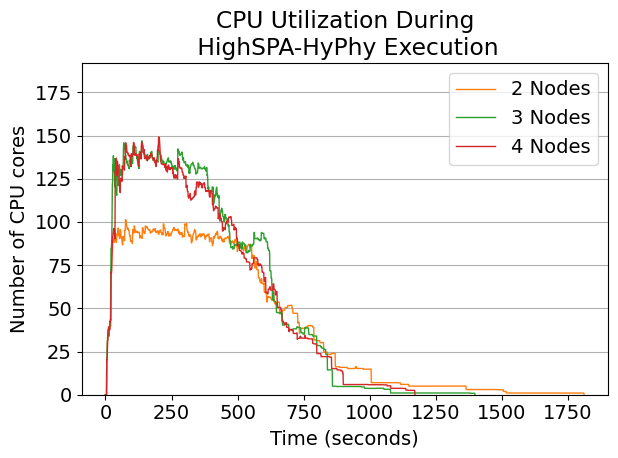

In [28]:
plt.rcParams.update({'font.size': 14})
colors = sns.color_palette(n_colors=4)
colors = colors[1:]
labels = ["2 Nodes", "3 Nodes", "4 Nodes"]
fig = plt.figure()
for d, c, l in zip(hyphy_array[1:], colors, labels):
    plt.plot([x for x in range(0, d['x'])], d['y'], color=c, label=l, linewidth=1, alpha=1)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of CPU cores")
    plt.title("CPU Utilization During\n HighSPA-HyPhy Execution")
    plt.legend()
    plt.grid(visible=True, axis='y')
plt.ylim([0, 192])
plt.savefig("fig.png", dpi=300)
plt.tight_layout()
plt.savefig("cpu_usage_hyphy.pdf", dpi=300)

## Codeml

In [4]:
codeml_1_node = get_data("./codeml/runinfo/", "04e09e19-bbcb-4ba8-ba12-4996e4966f18")

C:\Users\rafae\AppData\Local\Temp\ipykernel_16584\3155698091.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_timestamp'] = tmp['relative_time'].shift(1)
C:\Users\rafae\AppData\Local\Temp\ipykernel_16584\3155698091.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_cputime'] = tmp['total_cpu_time'].shift(1)
C:\Users\rafae\AppData\Local\Temp\ipykernel_16584\3155698091.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [5]:
codeml_2_nodes = get_data("./codeml/runinfo_multiple_nodes", "8e7f68eb-acf4-416d-962b-d6ed399ed31e")
codeml_3_nodes = get_data("./codeml/runinfo_multiple_nodes", "908868b9-09d7-4820-b535-2c7cfbb69040")
codeml_4_nodes = get_data("./codeml/runinfo_multiple_nodes", "1638ee7d-49b8-4348-a681-5e71ec663517")


codeml_array = [codeml_1_node, codeml_2_nodes, codeml_3_nodes, codeml_4_nodes]

C:\Users\rafae\AppData\Local\Temp\ipykernel_16584\3155698091.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_timestamp'] = tmp['relative_time'].shift(1)
C:\Users\rafae\AppData\Local\Temp\ipykernel_16584\3155698091.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['last_cputime'] = tmp['total_cpu_time'].shift(1)
C:\Users\rafae\AppData\Local\Temp\ipykernel_16584\3155698091.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

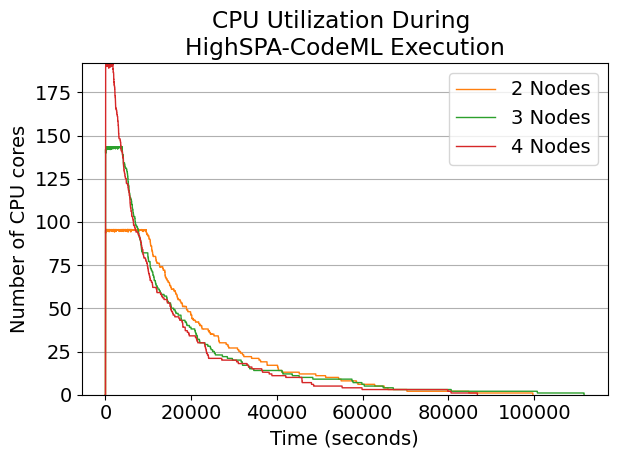

In [ ]:
plt.rcParams.update({'font.size': 14})
colors = sns.color_palette(n_colors=4)
colors = colors[1:]
labels = ["2 Nodes", "3 Nodes", "4 Nodes"]
fig = plt.figure()
for d, c, l in zip(codeml_array, colors, labels):
    plt.plot([x for x in range(0, d['x'])], d['y'], color=c, label=l, linewidth=1, alpha=1)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of CPU cores")
    plt.title("CPU Utilization During \nHighSPA-CodeML Execution")
    plt.legend()
    plt.grid(visible=True, axis='y')
plt.ylim([0, 192])
plt.tight_layout()
plt.savefig("codeml.png", dpi=300)
plt.savefig("cpu_usage_codeml.pdf", dpi=300)

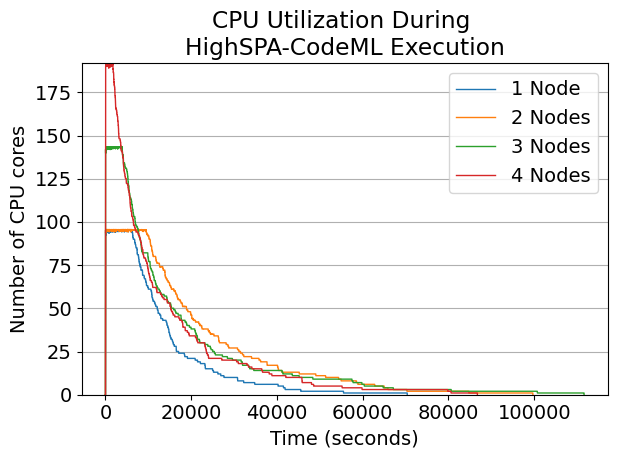

In [6]:
plt.rcParams.update({'font.size': 14})
colors = sns.color_palette(n_colors=4)
#colors = colors[]
labels = ["1 Node", "2 Nodes", "3 Nodes", "4 Nodes"]
fig = plt.figure()
for d, c, l in zip(codeml_array, colors, labels):
    plt.plot([x for x in range(0, d['x'])], d['y'], color=c, label=l, linewidth=1, alpha=1)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of CPU cores")
    plt.title("CPU Utilization During \nHighSPA-CodeML Execution")
    plt.legend()
    plt.grid(visible=True, axis='y')
plt.ylim([0, 192])
plt.tight_layout()
plt.savefig("codeml.png", dpi=300)
plt.savefig("cpu_usage_codeml.pdf", dpi=300)

# Calculating the time per task and theoretical runtime of a sequential execution

## HyPhy

In [8]:
hyphy_1_node = load_tasks("./runinfo", "dff22135-256c-4f04-904e-d8b5aad762fa")


In [9]:
avg_time_per_task = average_time_per_task(hyphy_1_node)
avg_time_per_task

{'mafft': 0.8964826358333333,
 'format_phylip': 2.0598068679166666,
 'raxml': 2.1280862275,
 'hyphy': 15.097749882916666}

In [10]:
time_per_gene = task_runtime_per_gene(hyphy_1_node)

['mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft']
['format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_p

In [11]:
avg_time_per_gene = sum(time_per_gene.values())/len(time_per_gene.values())

<BarContainer object of 40 artists>

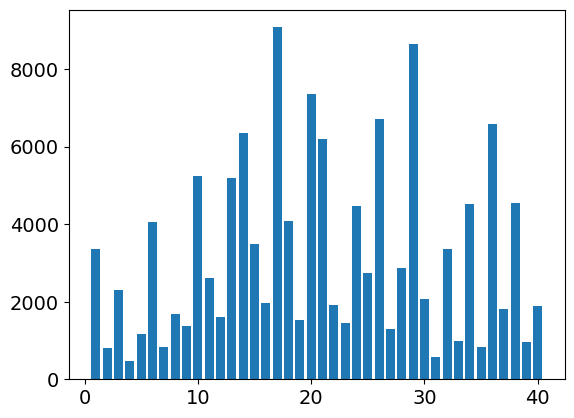

In [12]:
plt.bar(x=[x+1 for x in range(0, len(time_per_gene.keys()))], height = time_per_gene.values())

([0, 1, 2, 3, 4],
 [Text(0, 0, 'sequential time of 1 gene'),
  Text(1, 0, '1 Node'),
  Text(2, 0, '2 Nodes'),
  Text(3, 0, '3 Nodes'),
  Text(4, 0, '4 Nodes')])

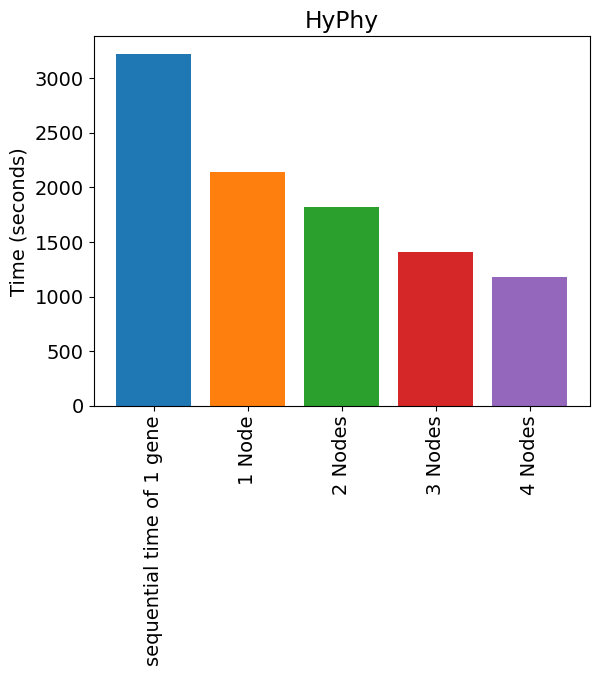

In [13]:
df = pd.DataFrame({
    "Nodes": [1,2,3,4],
    "Runtime (seconds)": [2141, 1818, 1406, 1179]
}, )
colors = sns.color_palette(n_colors=5)

plt.bar(x = ["sequential time of 1 gene", "1 Node", "2 Nodes", "3 Nodes", "4 Nodes"], height = [avg_time_per_gene, 2141, 1818, 1406, 1179], color=colors)
plt.title("HyPhy")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'sequential time of 1 gene'),
  Text(1, 0, '∑ sequential time of 40 genes'),
  Text(2, 0, '1 Node'),
  Text(3, 0, '2 Nodes'),
  Text(4, 0, '3 Nodes'),
  Text(5, 0, '4 Nodes')])

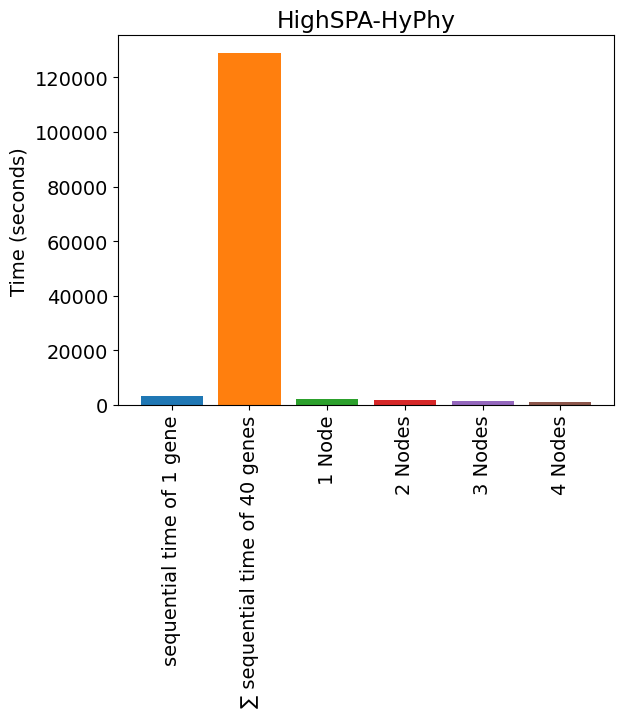

In [14]:
colors = sns.color_palette(n_colors=6)

plt.bar(x = ["sequential time of 1 gene", "∑ sequential time of 40 genes", "1 Node", "2 Nodes", "3 Nodes", "4 Nodes"], height = [avg_time_per_gene, avg_time_per_gene*40, 2141, 1818, 1406, 1179], color=colors)
plt.title("HighSPA-HyPhy")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=90)

In [15]:
times_hyphy = [x/60 for x in [avg_time_per_gene, avg_time_per_gene*40, 2141, 1818, 1406, 1179]]
print(times_hyphy)

[53.70454811458333, 2148.1819245833335, 35.68333333333333, 30.3, 23.433333333333334, 19.65]


Throughput

In [16]:
num_tasks = 360
for t in times_hyphy:
    print(num_tasks/t)

6.703342875763681
0.167583571894092
10.0887435777674
11.881188118811881
15.362731152204836
18.320610687022903


# Codeml

In [17]:
codeml_2_nodes = load_tasks("../codeml/runinfo_multiple_nodes", "8e7f68eb-acf4-416d-962b-d6ed399ed31e")

In [18]:
avg_time_per_task = average_time_per_task(codeml_2_nodes)
avg_time_per_task

{'mafft': 0.7355719475,
 'format_phylip': 14.030293664999999,
 'raxml': 14.084775534999999,
 'codeml': 408.2977511095833}

In [19]:
time_per_gene = task_runtime_per_gene(codeml_2_nodes)
avg_time_per_gene = sum(time_per_gene.values())/len(time_per_gene.values())


['mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft', 'mafft']
['format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_phylip', 'format_p

<BarContainer object of 40 artists>

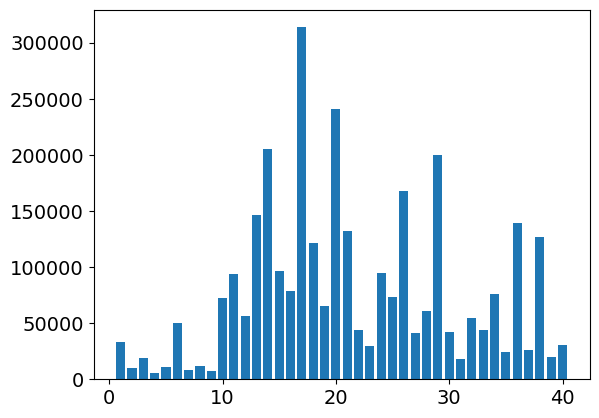

In [20]:
plt.bar(x=[x+1 for x in range(0, len(time_per_gene.keys()))], height = time_per_gene.values())

([0, 1, 2, 3, 4],
 [Text(0, 0, 'sequential time of 1 gene'),
  Text(1, 0, '∑ sequential time of 40 genes'),
  Text(2, 0, '2 Nodes'),
  Text(3, 0, '3 Nodes'),
  Text(4, 0, '4 Nodes')])

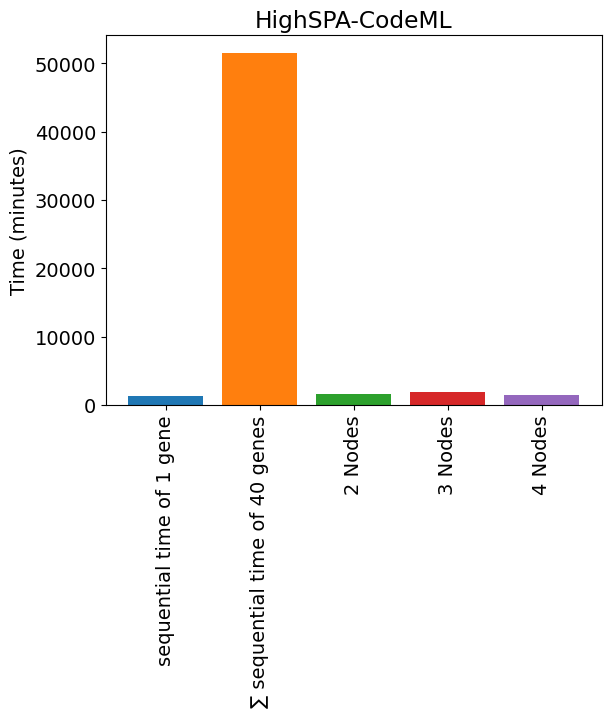

In [21]:
colors = sns.color_palette(n_colors=6)
times_codeml = [avg_time_per_gene/60, (avg_time_per_gene*40)/60, 1661.55,  1860.5, 1445.92]
plt.bar(x = ["sequential time of 1 gene", "∑ sequential time of 40 genes", "2 Nodes", "3 Nodes", "4 Nodes"], height = times_codeml, color=colors)
plt.title("HighSPA-CodeML")
plt.ylabel("Time (minutes)")
plt.xticks(rotation=90)

In [22]:
print(times_codeml)

[1288.082605574583, 51523.30422298332, 1661.55, 1860.5, 1445.92]


Throughput

In [23]:
num_tasks = 360
for t in times_codeml:
    print(num_tasks/t)

0.27948518087425966
0.006987129521856491
0.2166651620474858
0.19349637194302607
0.24897643023127142
